# Extracted the Code from the Librosa Library and simplified the code
Simplifications by David Schulz

In [430]:
from librosa import load, ex, display
import numpy as np
import scipy
from numpy.lib.stride_tricks import as_strided

In [431]:
# Copyright (c) 2013--2023, librosa development team.

MAX_MEM_BLOCK = 2**8 * 2**10
__FFTLIB = None

In [432]:
class Deprecated(object):
    """A placeholder class to catch usage of deprecated variable names"""

    def __repr__(self) -> str:
        """Pretty-print display for deprecated objects"""
        return "<DEPRECATED parameter>"

In [679]:
def mfcc(
    *,
    y = None,
    sr = 22050,
    n_mfcc = 20,
    dct_type = 2,
    norm = "ortho",
    lifter: float = 0,
    mel_norm = "slaney"
):

    S = power_to_db(melspectrogram(y=y, sr=sr))

    return scipy.fftpack.dct(S, axis=-2, type=dct_type, norm=norm)[..., :n_mfcc, :]

In [717]:
def melspectrogram(
    *,
    y = None,
    sr = 22050,
    n_fft = 2048,
    hop_length = 512,
    win_length = None,
    window = "hann",
    center= True,
    pad_mode = "constant",
    power = 2.0
):
    S, n_fft = _spectrogram(
        y=y,
        n_fft=n_fft,
        hop_length=hop_length,
        power=power,
        win_length=win_length,
        window=window,
        center=center,
        pad_mode=pad_mode,
    )

    # Build a Mel filter
    mel_basis = mel(sr=sr, n_fft=n_fft)

    return np.einsum("...ft,mf->...mt", S, mel_basis, optimize=True)

In [719]:
def power_to_db(S):
    ref = 1.0,
    amin = 1e-10,
    top_db = 80.0

    magnitude = S

    ref_value = np.abs(ref)

    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    return np.maximum(log_spec, log_spec.max() - top_db)

In [721]:
def _spectrogram(
    *,
    y = None,
    S = None,
    n_fft = 2048,
    hop_length = 512,
    power = 1,
    win_length = None,
    window = "hann",
    center = True,
    pad_mode = "constant",
):
    S = (
        np.abs(
            stft(
                y,
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                center=center,
                window=window,
                pad_mode=pad_mode,
            )
        )
        ** power
    )

    return S, n_fft

In [787]:
def stft(
    y,
    *,
    n_fft = 2048,
    hop_length = None,
    win_length = None,
    window = "hann",
    center = True,
    dtype = None,
    pad_mode = "constant",
    out = None,
):
    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)
    elif not is_positive_int(hop_length):
        raise ParameterError(f"hop_length={hop_length} must be a positive integer")

    # Check audio is valid
    valid_audio(y, mono=False)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = pad_center(fft_window, size=n_fft)

    # Reshape so that the window can be broadcast
    fft_window = expand_to(fft_window, ndim=1 + y.ndim, axes=-2)

    # Pad the time series so that frames are centered
    if center:
        if pad_mode in ("wrap", "maximum", "mean", "median", "minimum"):
            # Note: padding with a user-provided function "works", but
            # use at your own risk.
            # Since we don't pass-through kwargs here, any arguments
            # to a user-provided pad function should be encapsulated
            # by using functools.partial:
            #
            # >>> my_pad_func = functools.partial(pad_func, foo=x, bar=y)
            # >>> librosa.stft(..., pad_mode=my_pad_func)

            raise ParameterError(
                f"pad_mode='{pad_mode}' is not supported by librosa.stft"
            )

        if n_fft > y.shape[-1]:
            warnings.warn(
                f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
            )

        # Set up the padding array to be empty, and we'll fix the target dimension later
        padding = [(0, 0) for _ in range(y.ndim)]

        # How many frames depend on left padding?
        start_k = int(np.ceil(n_fft // 2 / hop_length))

        # What's the first frame that depends on extra right-padding?
        tail_k = (y.shape[-1] + n_fft // 2 - n_fft) // hop_length + 1

        if tail_k <= start_k:
            # If tail and head overlap, then just copy-pad the signal and carry on
            start = 0
            extra = 0
            padding[-1] = (n_fft // 2, n_fft // 2)
            y = np.pad(y, padding, mode=pad_mode)
        else:
            # If tail and head do not overlap, then we can implement padding on each part separately
            # and avoid a full copy-pad

            # "Middle" of the signal starts here, and does not depend on head padding
            start = start_k * hop_length - n_fft // 2
            padding[-1] = (n_fft // 2, 0)

            # +1 here is to ensure enough samples to fill the window
            # fixes bug #1567
            y_pre = np.pad(
                y[..., : (start_k - 1) * hop_length - n_fft // 2 + n_fft + 1],
                padding,
                mode=pad_mode,
            )
            y_frames_pre = frame(y_pre, frame_length=n_fft, hop_length=hop_length)
            # Trim this down to the exact number of frames we should have
            y_frames_pre = y_frames_pre[..., :start_k]

            # How many extra frames do we have from the head?
            extra = y_frames_pre.shape[-1]

            # Determine if we have any frames that will fit inside the tail pad
            if tail_k * hop_length - n_fft // 2 + n_fft <= y.shape[-1] + n_fft // 2:
                padding[-1] = (0, n_fft // 2)
                y_post = np.pad(
                    y[..., (tail_k) * hop_length - n_fft // 2 :], padding, mode=pad_mode
                )
                y_frames_post = frame(
                    y_post, frame_length=n_fft, hop_length=hop_length
                )
                # How many extra frames do we have from the tail?
                extra += y_frames_post.shape[-1]
            else:
                # In this event, the first frame that touches tail padding would run off
                # the end of the padded array
                # We'll circumvent this by allocating an empty frame buffer for the tail
                # this keeps the subsequent logic simple
                post_shape = list(y_frames_pre.shape)
                post_shape[-1] = 0
                y_frames_post = np.empty_like(y_frames_pre, shape=post_shape)
    else:
        if n_fft > y.shape[-1]:
            raise ParameterError(
                f"n_fft={n_fft} is too large for uncentered analysis of input signal of length={y.shape[-1]}"
            )

        # "Middle" of the signal starts at sample 0
        start = 0
        # We have no extra frames
        extra = 0

    fft = get_fftlib()

    if dtype is None:
        dtype = dtype_r2c(y.dtype)

    # Window the time series.
    y_frames = frame(y[..., start:], frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    shape = list(y_frames.shape)

    # This is our frequency dimension
    shape[-2] = 1 + n_fft // 2

    # If there's padding, there will be extra head and tail frames
    shape[-1] += extra

    if out is None:
        stft_matrix = np.zeros(shape, dtype=dtype, order="F")
    elif not (np.allclose(out.shape[:-1], shape[:-1]) and out.shape[-1] >= shape[-1]):
        raise ParameterError(
            f"Shape mismatch for provided output array out.shape={out.shape} and target shape={shape}"
        )
    elif not np.iscomplexobj(out):
        raise ParameterError(f"output with dtype={out.dtype} is not of complex type")
    else:
        if np.allclose(shape, out.shape):
            stft_matrix = out
        else:
            stft_matrix = out[..., : shape[-1]]

    # Fill in the warm-up
    if center and extra > 0:
        off_start = y_frames_pre.shape[-1]
        stft_matrix[..., :off_start] = fft.rfft(fft_window * y_frames_pre, axis=-2)

        off_end = y_frames_post.shape[-1]
        if off_end > 0:
            stft_matrix[..., -off_end:] = fft.rfft(fft_window * y_frames_post, axis=-2)
    else:
        off_start = 0

    n_columns = int(
        MAX_MEM_BLOCK // (np.prod(y_frames.shape[:-1]) * y_frames.itemsize)
    )
    n_columns = max(n_columns, 1)

    for bl_s in range(0, y_frames.shape[-1], n_columns):
        bl_t = min(bl_s + n_columns, y_frames.shape[-1])

        stft_matrix[..., bl_s + off_start : bl_t + off_start] = fft.rfft(
            fft_window * y_frames[..., bl_s:bl_t], axis=-2
        )
    return stft_matrix

In [789]:
def is_positive_int(x):
    # Check type first to catch None values.
    return isinstance(x, (int, np.integer)) and (x > 0)

In [791]:
def valid_audio(y, *, mono = Deprecated()):
    if not isinstance(y, np.ndarray):
        raise ParameterError("Audio data must be of type numpy.ndarray")

    if not np.issubdtype(y.dtype, np.floating):
        raise ParameterError("Audio data must be floating-point")

    if y.ndim == 0:
        raise ParameterError(
            f"Audio data must be at least one-dimensional, given y.shape={y.shape}"
        )

    if isinstance(mono, Deprecated):
        mono = False

    if mono and y.ndim != 1:
        raise ParameterError(
            f"Invalid shape for monophonic audio: ndim={y.ndim:d}, shape={y.shape}"
        )

    if not np.isfinite(y).all():
        raise ParameterError("Audio buffer is not finite everywhere")

    return True

In [793]:
def get_window(
    window,
    Nx,
    *,
    fftbins = True,
):
    if callable(window):
        return window(Nx)

    elif isinstance(window, (str, tuple)) or np.isscalar(window):
        # TODO: if we add custom window functions in librosa, call them here

        win: np.ndarray = scipy.signal.get_window(window, Nx, fftbins=fftbins)
        return win

    elif isinstance(window, (np.ndarray, list)):
        if len(window) == Nx:
            return np.asarray(window)

        raise ParameterError(f"Window size mismatch: {len(window):d} != {Nx:d}")
    else:
        raise ParameterError(f"Invalid window specification: {window!r}")

In [795]:
def pad_center(
    data, *, size, axis = -1, **kwargs
):
    kwargs.setdefault("mode", "constant")

    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise ParameterError(
            f"Target size ({size:d}) must be at least input size ({n:d})"
        )

    return np.pad(data, lengths, **kwargs)

In [797]:
def expand_to(
    x, *, ndim, axes
):
    # Force axes into a tuple
    axes_tup: Tuple[int]
    try:
        axes_tup = tuple(axes)  # type: ignore
    except TypeError:
        axes_tup = tuple([axes])  # type: ignore

    if len(axes_tup) != x.ndim:
        raise ParameterError(
            f"Shape mismatch between axes={axes_tup} and input x.shape={x.shape}"
        )

    if ndim < x.ndim:
        raise ParameterError(
            f"Cannot expand x.shape={x.shape} to fewer dimensions ndim={ndim}"
        )

    shape: List[int] = [1] * ndim
    for i, axi in enumerate(axes_tup):
        shape[axi] = x.shape[i]

    return x.reshape(shape)

In [799]:
def frame(
    x,
    *,
    frame_length,
    hop_length,
    axis = -1,
    writeable = False,
    subok = False,
):

    x = np.array(x, copy=False, subok=subok)

    if x.shape[axis] < frame_length:
        raise ParameterError(
            f"Input is too short (n={x.shape[axis]:d}) for frame_length={frame_length:d}"
        )

    if hop_length < 1:
        raise ParameterError(f"Invalid hop_length: {hop_length:d}")

    # put our new within-frame axis at the end for now
    out_strides = x.strides + tuple([x.strides[axis]])

    # Reduce the shape on the framing axis
    x_shape_trimmed = list(x.shape)
    x_shape_trimmed[axis] -= frame_length - 1

    out_shape = tuple(x_shape_trimmed) + tuple([frame_length])
    xw = as_strided(
        x, strides=out_strides, shape=out_shape, subok=subok, writeable=writeable
    )

    if axis < 0:
        target_axis = axis - 1
    else:
        target_axis = axis + 1

    xw = np.moveaxis(xw, -1, target_axis)

    # Downsample along the target axis
    slices = [slice(None)] * xw.ndim
    slices[axis] = slice(0, None, hop_length)
    return xw[tuple(slices)]

In [801]:
def dtype_r2c(d, *, default = np.complex64):
    mapping: Dict[DTypeLike, type] = {
        np.dtype(np.float32): np.complex64,
        np.dtype(np.float64): np.complex128,
        np.dtype(float): np.dtype(complex).type,
    }

    # If we're given a complex type already, return it
    dt = np.dtype(d)
    if dt.kind == "c":
        return dt

    # Otherwise, try to map the dtype.
    # If no match is found, return the default.
    return np.dtype(mapping.get(dt, default))

In [803]:
def get_fftlib():
    """Get the FFT library currently used by librosa

    Returns
    -------
    fft : module
        The FFT library currently used by librosa.
        Must API-compatible with `numpy.fft`.
    """
    if __FFTLIB is None:
        # This path should never occur because importing
        # this module will call set_fftlib
        assert False  # pragma: no cover

    return __FFTLIB


def set_fftlib(lib = None):

    global __FFTLIB
    if lib is None:
        from numpy import fft

        lib = fft

    __FFTLIB = lib

set_fftlib(None)

In [805]:
def mel(
    *,
    sr,
    n_fft,
    n_mels = 128,
    fmin = 0.0,
    fmax = None,
    htk = False,
    norm = "slaney",
    dtype = np.float32,
):
    if fmax is None:
        fmax = float(sr) / 2

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if isinstance(norm, str):
        if norm == "slaney":
            # Slaney-style mel is scaled to be approx constant energy per channel
            enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
            weights *= enorm[:, np.newaxis]
        else:
            raise ParameterError(f"Unsupported norm={norm}")
    else:
        weights = util.normalize(weights, norm=norm, axis=-1)

    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        warnings.warn(
            "Empty filters detected in mel frequency basis. "
            "Some channels will produce empty responses. "
            "Try increasing your sampling rate (and fmax) or "
            "reducing n_mels.",
            stacklevel=2,
        )

    return weights

In [807]:
def fft_frequencies(*, sr = 22050, n_fft = 2048):
    return np.fft.rfftfreq(n=n_fft, d=1.0 / sr)

In [809]:
def mel_frequencies(
    n_mels = 128, *, fmin = 0.0, fmax = 11025.0, htk = False
):
    # 'Center freqs' of mel bands - uniformly spaced between limits
    min_mel = hz_to_mel(fmin, htk=htk)
    max_mel = hz_to_mel(fmax, htk=htk)

    mels = np.linspace(min_mel, max_mel, n_mels)

    hz: np.ndarray = mel_to_hz(mels, htk=htk)
    return hz

In [811]:
def hz_to_mel(
    frequencies, *, htk = False
):
    frequencies = np.asanyarray(frequencies)

    if htk:
        mels: np.ndarray = 2595.0 * np.log10(1.0 + frequencies / 700.0)
        return mels

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (frequencies - f_min) / f_sp

    # Fill in the log-scale part

    min_log_hz = 1000.0  # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
    logstep = np.log(6.4) / 27.0  # step size for log region

    if frequencies.ndim:
        # If we have array data, vectorize
        log_t = frequencies >= min_log_hz
        mels[log_t] = min_log_mel + np.log(frequencies[log_t] / min_log_hz) / logstep
    elif frequencies >= min_log_hz:
        # If we have scalar data, heck directly
        mels = min_log_mel + np.log(frequencies / min_log_hz) / logstep

    return mels

In [813]:
def mel_to_hz(
    mels, *, htk = False
):
    mels = np.asanyarray(mels)

    if htk:
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0  # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
    logstep = np.log(6.4) / 27.0  # step size for log region

    if mels.ndim:
        # If we have vector data, vectorize
        log_t = mels >= min_log_mel
        freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))
    elif mels >= min_log_mel:
        # If we have scalar data, check directly
        freqs = min_log_hz * np.exp(logstep * (mels - min_log_mel))

    return freqs

In [815]:
y, sr = load(ex('libri1'))

In [817]:
mfccs = mfcc(y=y, sr=sr, n_mfcc=16)
mfccs

array([[-565.9194613 , -564.28805992, -562.84308008, ..., -437.97176722,
        -426.48356456, -434.66781209],
       [  10.30461676,   12.50870474,   14.13063173, ...,   89.98183514,
          88.43012141,   90.12025077],
       [   9.74848749,   11.67206972,   12.1390225 , ...,  -10.73086516,
         -10.77335902,   -5.22456194],
       ...,
       [   6.43103586,    7.01146229,    6.77968061, ...,   -6.22595059,
          -7.29734196,   -2.21974808],
       [   5.43160641,    5.56400194,    4.63668666, ...,    2.15356643,
           4.84169508,    5.67298347],
       [   4.42381533,    4.12633344,    2.23221949, ...,   10.92779237,
          12.51458006,   10.92853341]])

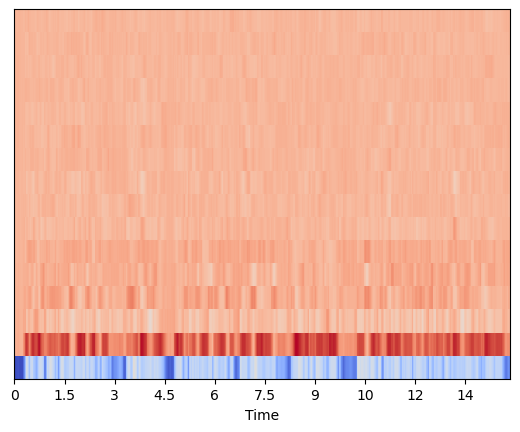

In [640]:
display.specshow(mfccs, x_axis='time')